# Data analysis - Relational data

*cugraph* que es una biblioteca acelerada por GPU para análisis de grafos, parte de la suite RAPIDS de NVIDIA. Activamos la variable de entorno para acelerar el calculo de métricas de los nodos del grafo haciendo uso de la GPU. Esto es fundamental para poder manipular el conjunto de datos con el que trabajaremos, que tiene un tamaño considerable.

In [3]:
# Configurando las variables de entorno
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


Importamos las librerías necesarias

In [2]:
# Librerias

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
# import cugraph as cg # networkx on gpu, no es necesario al tener activada la variable de entorno

## Dataset

Trabajaremos con el conjunto de datos de Kaggle "MUSAE GitHub Social Network"


https://www.kaggle.com/datasets/rozemberczki/musae-github-social-network/data

*A large social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. The task related to the graph is binary node classification - one has to predict whether the GitHub user is a web or a machine learning developer. This target feature was derived from the job title of each user.*

*The dataset consists an edge list, node features, and a target variable.*

In [3]:
# Datos
edges = pd.read_csv("../data/raw/musae_git_edges.csv")
features = pd.read_csv("../data/raw/musae_git_features.csv")
target = pd.read_csv("../data/raw/musae_git_target.csv")

Veamos cada uno de los conjuntos de datos con los que trabajaremos:

### Aristas 
Supondremos que se trata de un grafo no dirigido. Hay 289003 aristas y 37700 nodos.

In [18]:
print(edges.head())
print(edges.info())

   id_1   id_2
0     0  23977
1     1  34526
2     1   2370
3     1  14683
4     1  29982
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289003 entries, 0 to 289002
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   id_1    289003 non-null  int64
 1   id_2    289003 non-null  int64
dtypes: int64(2)
memory usage: 4.4 MB
None


### Features
Cada nodo tiene un atributo numérico del que no se dispone de más información a parte de que se ha extraido del usuario (*location, repositories starred, employer, e-mail address*). Toma valores entre 0 y 4004.

In [19]:
print(features.head())
print(features.info())

   node  feature
0     0     1574
1     0     3773
2     0     3571
3     0     2672
4     0     2478
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690374 entries, 0 to 690373
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   node     690374 non-null  int64
 1   feature  690374 non-null  int64
dtypes: int64(2)
memory usage: 10.5 MB
None


In [22]:
features.describe()

,node,feature
count,690374.000000,690374.000000
mean,18840.811856,1996.149079
std,10886.460545,1168.463607
min,0.000000,0.000000
25%,9416.000000,1022.000000
50%,18836.000000,1852.000000
75%,28276.000000,3077.000000
max,37699.000000,4004.000000


In [21]:
features.nunique()

node       37700
feature     4005
dtype: int64

Text(0.5, 1.0, 'Histograma feature')

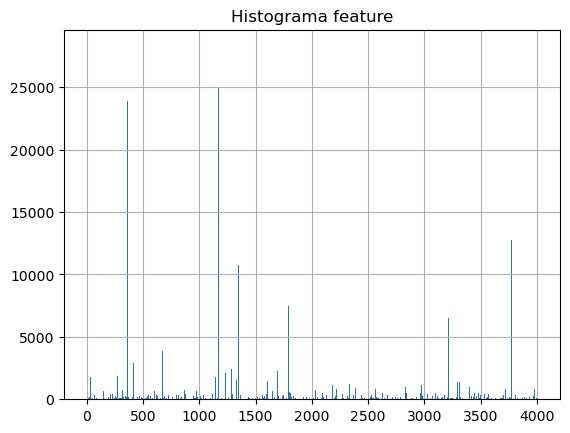

In [26]:
features["feature"].hist(bins=2000)
plt.title("Histograma feature")

No todos los valores de "feature" aparecen con la misma frecuencia. Hay valores más comunes que otros. Habrá que ver como tratarlo.

### Target
Variable binaria indicando si el usuario es un desarrollador web o de ML. No se indica que clase corresponde a cual, pero para nuestro objetivo esto es indiferente.

In [14]:
print(target.head())
print(target.info())

   id          name  ml_target
0   0        Eiryyy          0
1   1    shawflying          0
2   2   JpMCarrilho          1
3   3     SuhwanCha          0
4   4  sunilangadi2          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37700 entries, 0 to 37699
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         37700 non-null  int64 
 1   name       37700 non-null  object
 2   ml_target  37700 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 883.7+ KB
None


Hay una variable identificadora, el nombre del usuario, que no nos es útil.

In [27]:
target["ml_target"].value_counts()

ml_target
0    27961
1     9739
Name: count, dtype: int64

Vemos que hay 27961 elementos de la clase 0 frente a los 9739. Se trata por tanto de un problema de **clasificación no balanceada**, por lo que habrá que actuar en consonancia.

## Análisis del grafo
En esta sección construiremos el grafo de datos el cual se analizará a través de distintas métricas de grafos estudiadas en clase, con el objetivo de conocer qué características tiene la red a la que nos enfrentamos. 

Para construir el grafo y calcular las métricas se empleará *networkx* con el backend de *cugraph* para acelerar la computacion haciendo uso de la GPU. Puede consultarse más información al respecto en https://docs.rapids.ai/api/cugraph/stable/ y https://rapids.ai/nx-cugraph/.

### Construcción del grafo

Se construye el grafo no dirigio a partir del DataFrame

In [29]:
G = nx.from_pandas_edgelist(edges,'id_1','id_2')

In [ ]:
# Se necesita una forma más eficiente de hacer la representación
# plt.figure(figsize=(40,40))
# nx.draw(G,alpha=0.5,node_color=target["ml_target"])

### Métricas del grafo

##### Distribución de grados 
EL grado de un nodo es el número de nodos conectados conectados con el. En este caso normalizado dividiendo por n-1, entre 0 y 1.

            degrees
count  37700.000000
mean       0.000407
std        0.002143
min        0.000027
25%        0.000053
50%        0.000159
75%        0.000345
max        0.250882


Text(0, 0.5, 'Número de nodos')

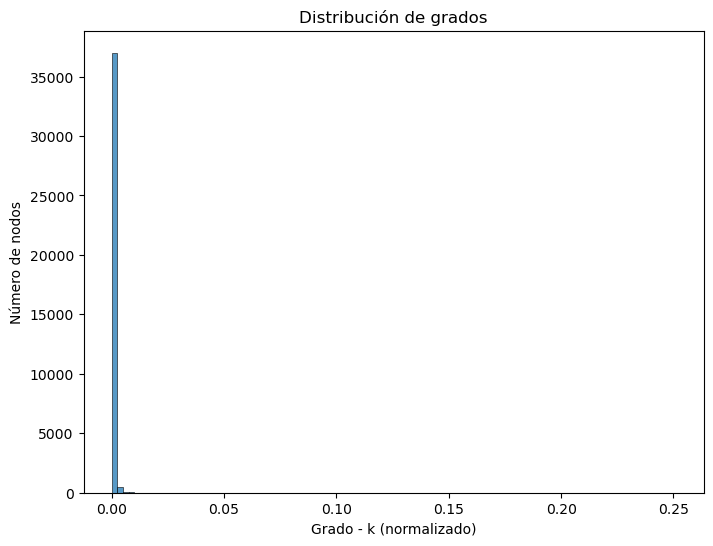

In [33]:
degrees = nx.degree_centrality(G)
print(pd.DataFrame.from_dict(degrees,orient="index",columns=["degrees"]).describe())

plt.figure(figsize=(8, 6))
sns.histplot(degrees,bins=100)
plt.title("Distribución de grados")
plt.xlabel("Grado - k (normalizado)")
plt.ylabel("Número de nodos")

Muchos con poco y (muy) pocos con mucho. CONCENTRADORES.

Para ver si se trata de una distribución libre de escala vamos a hacer el gráfico de la distribución de grados log-log

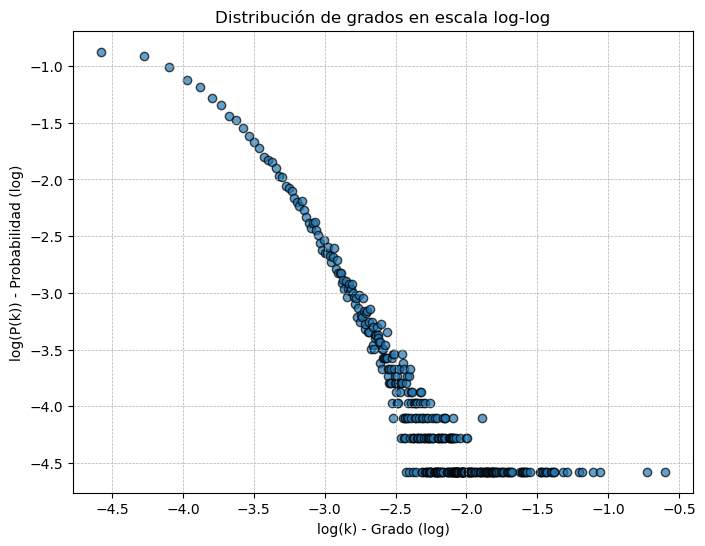

In [38]:
from scipy.stats import linregress

degree_counts = pd.Series(degrees).value_counts().sort_index()  # Frecuencias de cada grado
p_k = degree_counts / degree_counts.sum()  # Normalizar para obtener P(k)

# Convertir a escala log-log
log_k = np.log10(degree_counts.index)  # Logaritmo del grado
log_p_k = np.log10(p_k.values)  # Logaritmo de la probabilidad

# Graficar
plt.figure(figsize=(8, 6))
plt.scatter(log_k, log_p_k, alpha=0.7, edgecolor='k')
plt.title("Distribución de grados en escala log-log")
plt.xlabel("log(k) - Grado (log)")
plt.ylabel("log(P(k)) - Probabilidad (log)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

A simple vista ya vemos que aunque no se trata de una distribución libre de escala "teórica" (que se correspondería con una línea recta),  sí que se aproxima. Añadamos el regresor lineal para verlo con más claridad.

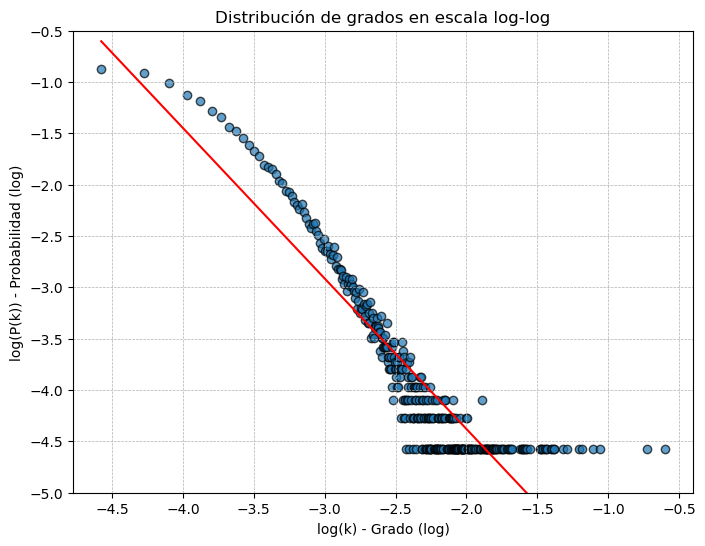

In [41]:
# Ajustar la regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(log_k, log_p_k)

# Crear la línea de regresión
regression_line = slope * log_k + intercept

# Graficar
plt.figure(figsize=(8, 6))
plt.scatter(log_k, log_p_k, alpha=0.7, edgecolor='k')
plt.plot(log_k, regression_line, color='red', label=f"Regresión lineal (slope={slope:.2f})")
plt.ylim((-5,-0.5))
plt.title("Distribución de grados en escala log-log")
plt.xlabel("log(k) - Grado (log)")
plt.ylabel("log(P(k)) - Probabilidad (log)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Se asemeja mucho a una topología libre de escala.

#### Distribución de clustering
El coeficiente de clustering de un nodo es la probabilidad de que dos nodos vecinos a este, sean vecinos entre sí

         clustering
count  37700.000000
mean       0.167537
std        0.225168
min        0.000000
25%        0.000000
50%        0.100000
75%        0.226316
max        1.000000


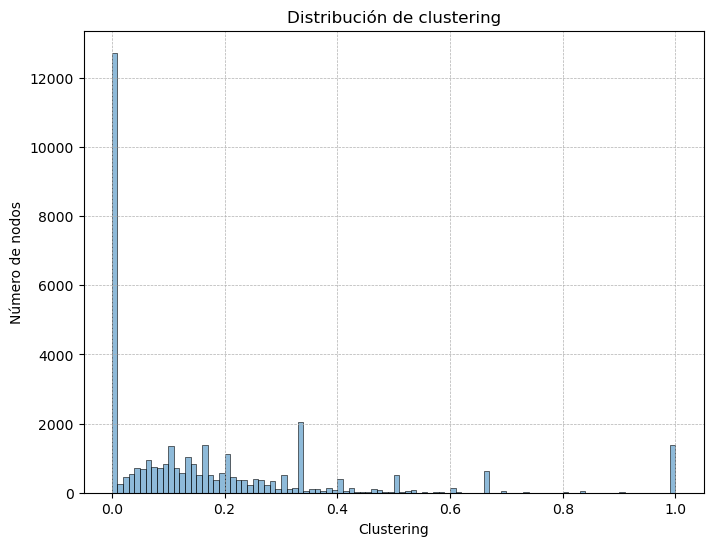

In [ ]:
clustering = nx.clustering(G)
print(pd.DataFrame.from_dict(clustering,orient="index",columns=["clustering"]).describe())

plt.figure(figsize=(8, 6))
sns.histplot(clustering.values(),bins=100,legend=False)
plt.title("Distribución de clustering")
plt.xlabel("Clustering")
plt.ylabel("Número de nodos")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Sabemos que en los árboles el coeficiente de clustering es 0, pues no hay ciclos. En los grafos aleatorios el coeficiente de clustering es igual a la probabilidad de que dos nodos cualesquiera sea vecinos entre sí, por lo que es constante. En las redes complejas se obsevan regiones altamente cohesivas no conectadas entre sí. Este último parece ser el caso que observamos: 
- Gran número de nodos con coeficiente de clustering 0
- Número elevado de nodos con coeficiente de nodos con coeficiente de clustering que oscila entre 0 y 0.4.
- Casi 20k nodos con coeficiente de clustering muy cercano a 1.

Coeficiente de clustering medio:

In [ ]:
global_cluster = nx.average_clustering(G, count_zeros=True)
global_cluster

0.16753704480107584

#### Centralidad betweennes

También llamada carga o intermediación, mide la proporción de geodésicas entre nodos del grafo que pasan por un uno dado. Da una idea de la importancia de un nodo en el tráfico de la red. 

**Muy costosa computacionalmente** (en mi máquina tarda unos 9 min en calcularse para todo el grafo haciendo uso de la GPU).

        betweenness
count  3.770000e+04
mean   5.958963e-05
std    1.949917e-03
min    0.000000e+00
25%    4.495291e-08
50%    1.529294e-06
75%    1.728025e-05
max    2.695983e-01


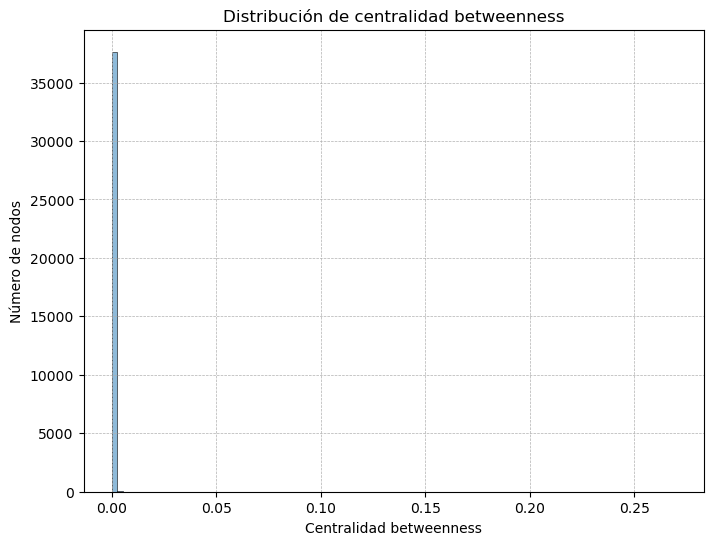

In [ ]:
betweenness = nx.betweenness_centrality(G)
print(pd.DataFrame.from_dict(betweenness,orient="index",columns=["betweenness"]).describe())

plt.figure(figsize=(8, 6))
sns.histplot(betweenness.values(),bins=100,legend=False)
plt.title("Distribución de centralidad betweenness")
plt.xlabel("Centralidad betweenness")
plt.ylabel("Número de nodos")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [49]:
pd.DataFrame.from_dict(betweenness,orient="index",columns=["betweenness"]).sort_values(by = "betweenness",ascending=False).head(10)

,betweenness
31890,0.269598
27803,0.240542
19222,0.055323
35773,0.043408
13638,0.035338
36652,0.030840
10001,0.027612
18163,0.025799
33671,0.021260
19253,0.020315


Esto es interesante, vemos que la gran mayoría de los nodos tienen una centralidad betwenness muy baja (el 75% de los nodos tiene un valor inferior a 1.7e-5), lo que indica no son importantes en el tráfico de la red. Sin embargo, vemos que hay dos nodos con un valor de 0.26 y 0.24. Es decir, cada uno de estos nodos controla el 25% del tráfico de la red, entendiendo por ello que el 25% de los caminos más cortos entre dos nodos del grafo cualesquiera lo atraviesa.Son dos **SUPERCONCENTRADORES** (ids 31890 y 27803). Además de estos hay un cierto número de nodos con un valor de la centralidad elevado, superiores al 0.01. Que actúan de concentradores en su entorno.

Interprendalo, en el contexto de los datos, hay dos desarrolladores que son super populares entre los desarrolladores considerados. Los estudiaremos a fondo más a delante.

#### Centralidad closeness

Es el promedio de las distancias de un nodo a todos los demás. En este caso se usa el recíproco.

**Muy costoso computacionalmente** (en mi máquina 10min con GPU).

          closeness
count  37700.000000
mean       0.313667
std        0.040806
min        0.141389
25%        0.284141
50%        0.311260
75%        0.346949
max        0.523081


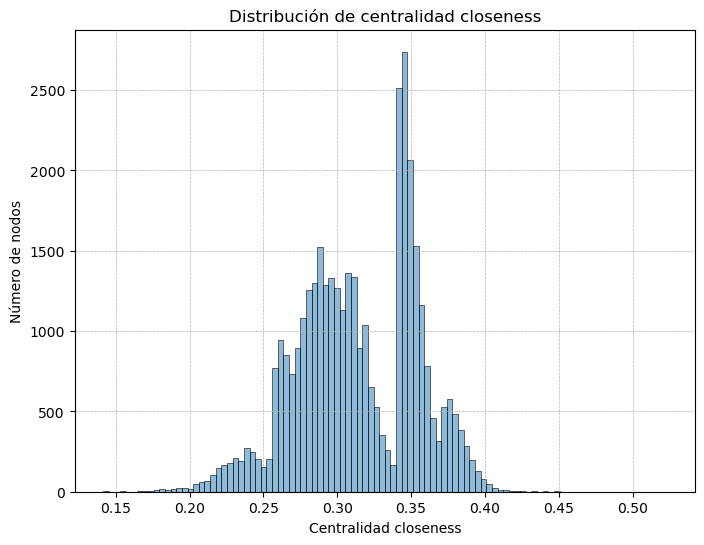

In [ ]:
closeness = nx.closeness_centrality(G) # Reciproco de la distancia media de un nodo a todos los demás
print(pd.DataFrame.from_dict(closeness,orient="index",columns=["closeness"]).describe())


plt.figure(figsize=(8, 6))
sns.histplot(closeness.values(),bins=100,legend=False)
plt.title("Distribución de centralidad closeness")
plt.xlabel("Centralidad closeness")
plt.ylabel("Número de nodos")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


Vemos que la distancia media entre los nodos es, en general, muy baja. La centralidad closeness oscila entre 0.14 y 0.52, lo que significa que la distancia media entre un nodo y todos los demás en el grafo oscila entre 1.92 y 7.14 (el recíproco). Obervamos, por tanto, la **propiedad Small World**, es decir, los nodos se encuentran muy cercas unos de otros. 

Uniendo esto a lo que vimos en la distribuciín de grados y en la centralidad betweenness, podemos deducir que se debe a la existencia de superconcentradores y concentradores que hacen de intermediarios para conectar los nodos del grafo entre sí.

In [55]:
pd.DataFrame.from_dict(closeness,orient="index",columns=["closeness"]).sort_values(by="closeness", ascending=False).head(10)


,closeness
27803,0.523081
31890,0.517787
19222,0.466324
35773,0.450342
13638,0.447461
19253,0.447333
36628,0.442986
10001,0.442253
36652,0.439597
22881,0.431734


De nuevo vemos que los dos concentradores (ids 2783 y 31890) son los que tienen un mayor coeficiente de centrealidad closeness. Ambos se encuentran a una distancia media de 2 de cualquier otro nodo del grafo.

#### Centralidad del autovalor
Mide la influencia de un nodo en el grafo, y corresponde con el autovalor principal de la matriz de adyacencia del grafobanalizado. La interpretación es similar a la carga, pero esta métrica presenta la ventaja de que computacionalmente es mucho más eficiente.

           pagerank
count  3.770000e+04
mean   2.372860e-03
std    4.571137e-03
min    3.543991e-12
25%    1.671726e-04
50%    1.083887e-03
75%    3.186920e-03
max    3.559468e-01


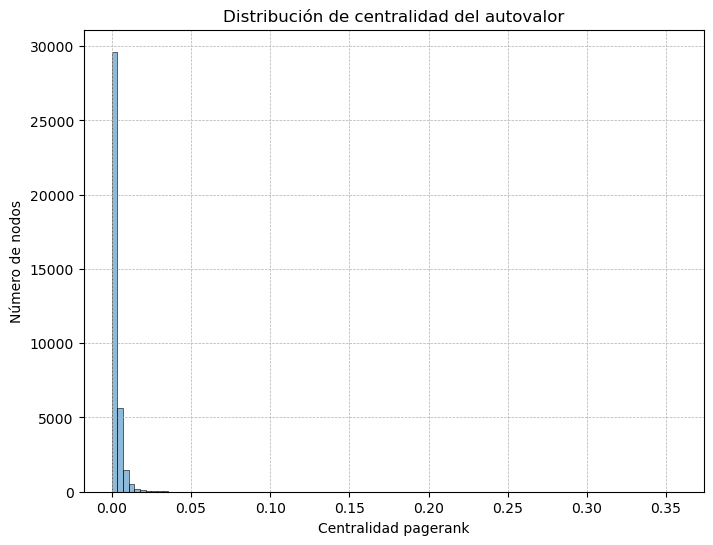

In [74]:
pagerank = nx.eigenvector_centrality(G)
print(pd.DataFrame.from_dict(pagerank,orient="index",columns=["pagerank"]).describe())

plt.figure(figsize=(8, 6))
sns.histplot(pagerank.values(),bins=100,legend=False)
plt.title("Distribución de centralidad del autovalor")
plt.xlabel("Centralidad pagerank")
plt.ylabel("Número de nodos")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [52]:
pd.DataFrame.from_dict(pagerank,orient="index",columns=["pagerank"]).sort_values(by="pagerank", ascending=False).head(10)


,pagerank
31890,0.355947
27803,0.301655
35773,0.161677
19222,0.148842
13638,0.119461
36652,0.095699
7027,0.088758
36628,0.087670
9051,0.082797
3712,0.081374


De nuevo vemos que los nodos 31890 y 27803 son los más populares, teniendo en cuenta la centalidad del pagerank. Aquí observamos comentarios similares a los que se han hecho con la centralidad betweenness. Dos nodos super populares y un cierto número de nodos populares mientra sque la gran mayoría de los nodos presentan valores muy reducidos, indicando que no son populares dentro de la red. 

#### Componentes conexas
Una componente conexa de un grafo es un subgrafo tal que 
- Todos los nodos que los componen están conectado por un camino 
- No hay caminos entre ningún nodo de esta componente y nodos fuera de ella.

In [ ]:
# Vemos el número de nodos que componen cada una de las componentes conexas del grafo
[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]

Solo existe una única componente conexa en el grafo que contiene a todos los nodos.

## Conclusiones
Estamos ante un grafo conexo que puede ser considerado una **red compleja**, ya que:
- Distribución libre de escala.
- Propiedad Small World.
- Dos superconcentradores (ids 31890 y 27803) que juegan un papel central en la red. Fenómeno *the rich get richer*.
- Concentradores menores que ayudan a conectar la red.
- La gran mayoría de nodos con muy poca relevancia en el grafo.

Los superconcentradores de la red:

In [4]:
target.iloc[[31890,27803]]

,id,name,ml_target
31890,31890,dalinhuang99,0
27803,27803,nfultz,0


Ambos tienen etiqueta 0, esto puede jugar un papel importante en la clasificación de los nodos.

## Data export
Exportamos los datos que serán a usados para entrenar modelos de ML a partir de las características extraídas manualmente.

In [63]:
X = np.transpose(pd.DataFrame([degrees.values(),clustering.values(), closeness.values(),
                   pagerank.values(), betweenness.values()]))
X.columns = ["degree", "clustering", "closeness", "pagerank", "betweenness"]

print(X.head(5))
print(X.iloc[[31890,27803]]) # Los superconcentradores

X.to_csv("../data/processed/X_selected_features.csv", index=False)

     degree  clustering  closeness  pagerank   betweenness
0  0.000027    0.000000   0.275027  0.000047  0.000000e+00
1  0.000212    0.178571   0.294980  0.000952  1.149915e-06
2  0.000027    0.000000   0.261866  0.000036  0.000000e+00
3  0.000133    0.000000   0.278740  0.000105  5.317143e-05
4  0.000053    0.000000   0.243103  0.000009  6.135293e-09
         degree  clustering  closeness  pagerank  betweenness
31890  0.250882    0.001413   0.517787  0.355947     0.269598
27803  0.187936    0.003199   0.523081  0.301655     0.240542
